# Subscription Predictions for Minecraft Player’s Demographics 
# – Group 15

**Mary Leung (34578872), Mia Pu (52408770), Takuma Wang (90577297), Thanisha Dhande (29710449)**

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(themis)
library(dplyr)
options(jupyter.plot_mimetypes = "image/png")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction ##

Minecraft, the classic game from our childhoods, is the go-to after-school game. While people had fun playing, there was a whole other world studying the demographics and data that was collected. Looking from the point of view of the producers and creators who want to promote their game, how would they do so?

A group from UBC’s Computer Science class created a Minecraft server and collected data similar to what the actual game may have collected. In a file called <code>players.csv</code> , they gathered demographic and skill level information. Our group is using this data set to predict whether players with different experience and gender demographics will subscribe to game-related newsletters based on their age and time spent playing on the Minecraft server.

In the players.csv, there are multiple columns:
- <code>Experience</code>: this categorizes players into five skill levels (Amateur, Beginner, Regular, Pro, Veteran).
- <code>Subscribe</code>: this tells us whether the individual is subscribed to gaming-related newsletters or not.
- <code>hashedEmail</code>: This is a unique ID given to each player to identify them easily.
- <code>Played hours</code>: This tells us how long each player played in total.
- <code>Name</code>: name of player
- <code>Gender</code>: what each of the players identifies as ('Agender', 'Female', 'Male', 'Non-binary', 'Other', 'Two-Spirited', 'Prefer not to say')
- <code>Age</code>: how old the players are.

We will be using the variables experience, played hours, gender, and age as factors in our classification model to predict whether the player will subscribe or not. Out of the seven gender options, we will be focusing on <code>Female</code> and <code>Male</code>, as the other five do not have enough observations to make a reasonable conclusion. The other variables, such a <code>hashedEmail</code> and <code>name</code>, will not be of use, as we don’t need the specific identity of each player. The variable subscribe will be used as the target variable, as that is what we are trying to predict.


## Methods and Results ##

In [2]:
players <- read_csv("players.csv")

players_tidy <- players |>
    mutate(age=Age) |>
    select(subscribe, age, played_hours, experience, gender) |>
    filter(!is.na(age)) |>
    filter(played_hours > 0) |>
    mutate(subscribe=as.factor(subscribe))
head(players_tidy)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,age,played_hours,experience,gender
<fct>,<dbl>,<dbl>,<chr>,<chr>
TRUE,9,30.3,Pro,Male
TRUE,17,3.8,Veteran,Male
TRUE,21,0.7,Amateur,Female
TRUE,21,0.1,Regular,Male
TRUE,47,0.1,Amateur,Male
TRUE,23,1.6,Veteran,Female


In [3]:
# assigned 0 or 1 to experience and gender depending on if the obervation was in that category.
# If the obervation was of a Female Pro the columns "experience_Pro" and "Female" would have 1 and the others would have 0.

players_experience <- players |>
    mutate(value=1) |>
    pivot_wider(names_from=experience, 
                names_prefix="experience_",
                values_from=value, 
                values_fill=list(value=0))

players_wrangled <- players_experience |>
    filter(gender %in% c("Male", "Female")) |>
    mutate(value=1) |>
    pivot_wider(names_from=gender,
                values_from=value,
                values_fill=list(value=0)) |>
    select(-hashedEmail, -name) |>
    mutate(subscribe=as.factor(subscribe))
head(players_wrangled)


subscribe,played_hours,Age,experience_Pro,experience_Veteran,experience_Amateur,experience_Regular,experience_Beginner,Male,Female
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TRUE,30.3,9,1,0,0,0,0,1,0
TRUE,3.8,17,0,1,0,0,0,1,0
FALSE,0.0,17,0,1,0,0,0,1,0
TRUE,0.7,21,0,0,1,0,0,0,1
TRUE,0.1,21,0,0,0,1,0,1,0
TRUE,0.0,17,0,0,1,0,0,0,1


We first imported the data from <code>player.csv</code>, which includes all the observations. Then, we created a cleaned version called <code>players_wrangled</code> by:
- renaming the variable age to Age
- selecting the columns needed: <code>subscribe</code>, <code>age</code>, <code>played_hours</code>, <code>experience</code>, <code>gender</code>
- removing observations with missing age values
- removing observations with played_hours ≤ 0
- converting the subscription variable into a factor to make it a categorical outcome for KNN classification

Next, we converted <code>experience</code> and <code>gender</code> variables into binary indicators so KNN can use them as numeric values to calculate distance in classification. To do this, we first kept players whose gender was recorded as <code>Male</code> or <code>Female</code>. Then, we expanded the <code>experience</code> and <code>gender</code> from a single categorical column into multiple binary columns (e. experience_Pro, experience_Veteran, Male…) where 1 indicates presence while 0 indicates absence. And the non-informative identifiers (hashedEmail and name) were removed at the end.


In [4]:
players_rows <- nrow(players_wrangled)
players_rows

[1] 161

In [5]:
summary_stats <- summary(players_wrangled)
summary_stats

 subscribe    played_hours          Age        experience_Pro   
 FALSE: 39   Min.   :  0.000   Min.   : 9.00   Min.   :0.00000  
 TRUE :122   1st Qu.:  0.000   1st Qu.:17.00   1st Qu.:0.00000  
             Median :  0.100   Median :19.00   Median :0.00000  
             Mean   :  5.623   Mean   :21.07   Mean   :0.06832  
             3rd Qu.:  0.700   3rd Qu.:22.00   3rd Qu.:0.00000  
             Max.   :223.100   Max.   :58.00   Max.   :1.00000  
 experience_Veteran experience_Amateur experience_Regular experience_Beginner
 Min.   :0.0000     Min.   :0.0000     Min.   :0.0000     Min.   :0.0000     
 1st Qu.:0.0000     1st Qu.:0.0000     1st Qu.:0.0000     1st Qu.:0.0000     
 Median :0.0000     Median :0.0000     Median :0.0000     Median :0.0000     
 Mean   :0.2236     Mean   :0.3354     Mean   :0.1863     Mean   :0.1863     
 3rd Qu.:0.0000     3rd Qu.:1.0000     3rd Qu.:0.0000     3rd Qu.:0.0000     
 Max.   :1.0000     Max.   :1.0000     Max.   :1.0000     Max.   :1.0000     

##### subscribe #####
- There are 122 subscribers (<code>TRUE</code>) and 39 non-subscribers (<code>FALSE</code>).
- A majority of players choose to subscribe.
##### played_hours #####
- Minimum: 0 hours
- Median: 0.10 hours
- Mean: 5.62 hours
- Maximum: 223.1 hours
- Most players play a few hours, but a small number of players play a lot.
- The distribution is right-skewed.
##### Age #####
- Range: 9 to 58 years
- Median: 19 years
- Mean: 21.07 years
- Most players are teenagers or young adults.


Both experience and gender categories were converted into 0 or 1. In this case, mean values represent the proportion of players in each group rather than numerical averages.
##### experience #####
- experience_Pro: about 6.8% of players are “Pro”
- experience_Veteran: about 22.4% of players are “Veteran”
- experience_Amateur: about 33.5% of players are “Amateur”
- experience_Regular: about 18.6% of players are “Regular”
- experience_Beginner:  about 18.6% of players are “Beginner”
- Amateur players is the largest experience group
##### gender #####
During the wrangling, we kept only “Male” and “Female” and filtered out other gender categories (Non-binary, Prefer not to say…) due to low counts, preventing the KNN from instability.
- Male: about 77% of players are male.
- Female: about 23% of players are female
- A majority of players are male.


## Exploratory Data Visualizations ##

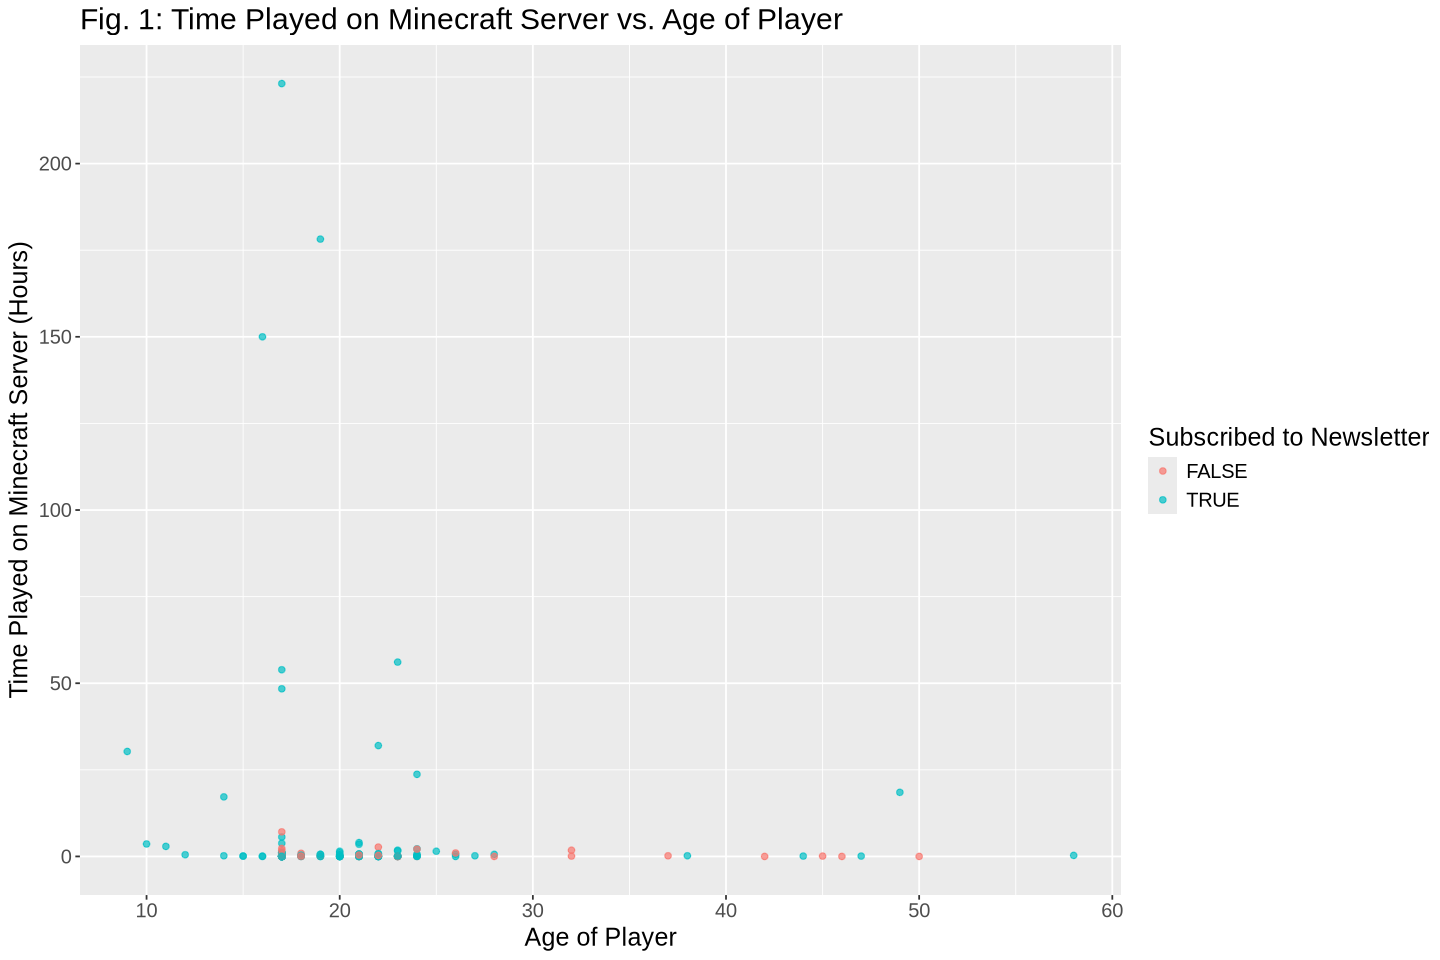

In [6]:
options(repr.plot.width=12, repr.plot.height=8)
players_plot <- ggplot(players_wrangled, aes(x=Age, y=played_hours, color=subscribe)) +
    geom_point(alpha=0.7) +
    labs(x="Age of Player", y="Time Played on Minecraft Server (Hours)", color="Subscribed to Newsletter", 
         title="Fig. 1: Time Played on Minecraft Server vs. Age of Player") +
    theme(text=element_text(size=15))
players_plot

<Fig. 1> This plot shows that both time played and age do not have a strong relationship with subscription behavior. Both subscribed and non-subscribed players are distributed in similar ranges, indicating time played and age alone may not be enough predictors to produce a precise classification. However, all players who played above 25 hours are subscribed

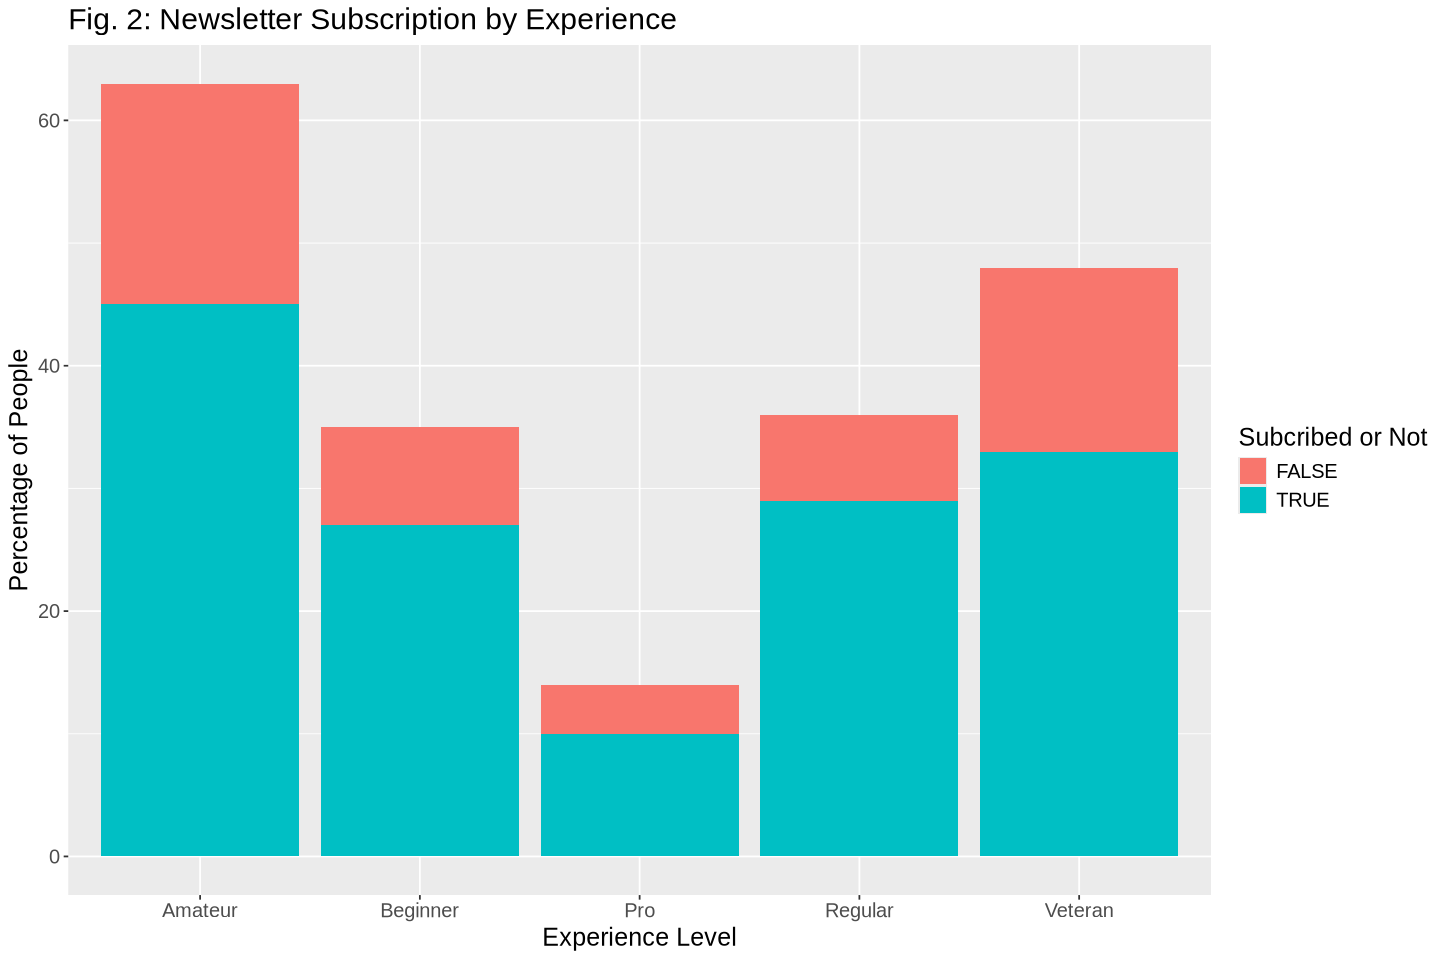

In [7]:
experience_prop_subscribe <- players|>
ggplot(aes(x=experience, fill=subscribe))+
geom_bar(position="stack")+
labs(x="Experience Level", y="Percentage of People", fill = "Subcribed or Not", title="Fig. 2: Newsletter Subscription by Experience")+
theme(text=element_text(size=15))
experience_prop_subscribe

<Fig. 2> This plot shows a difference in subscription rates across different experience levels. For example, <code>Veteran</code> and <code>Amateur</code> players have a much smaller blue portion in the stacked bars, indicating lower subscription rates, whereas <code>Regular</code> and <code>Beginner</code> players have a higher blue portion, indicating higher subscription rates. This difference in subscription rate across different levels suggests experience levels can separate the two classes, which are a better predictor for classification.

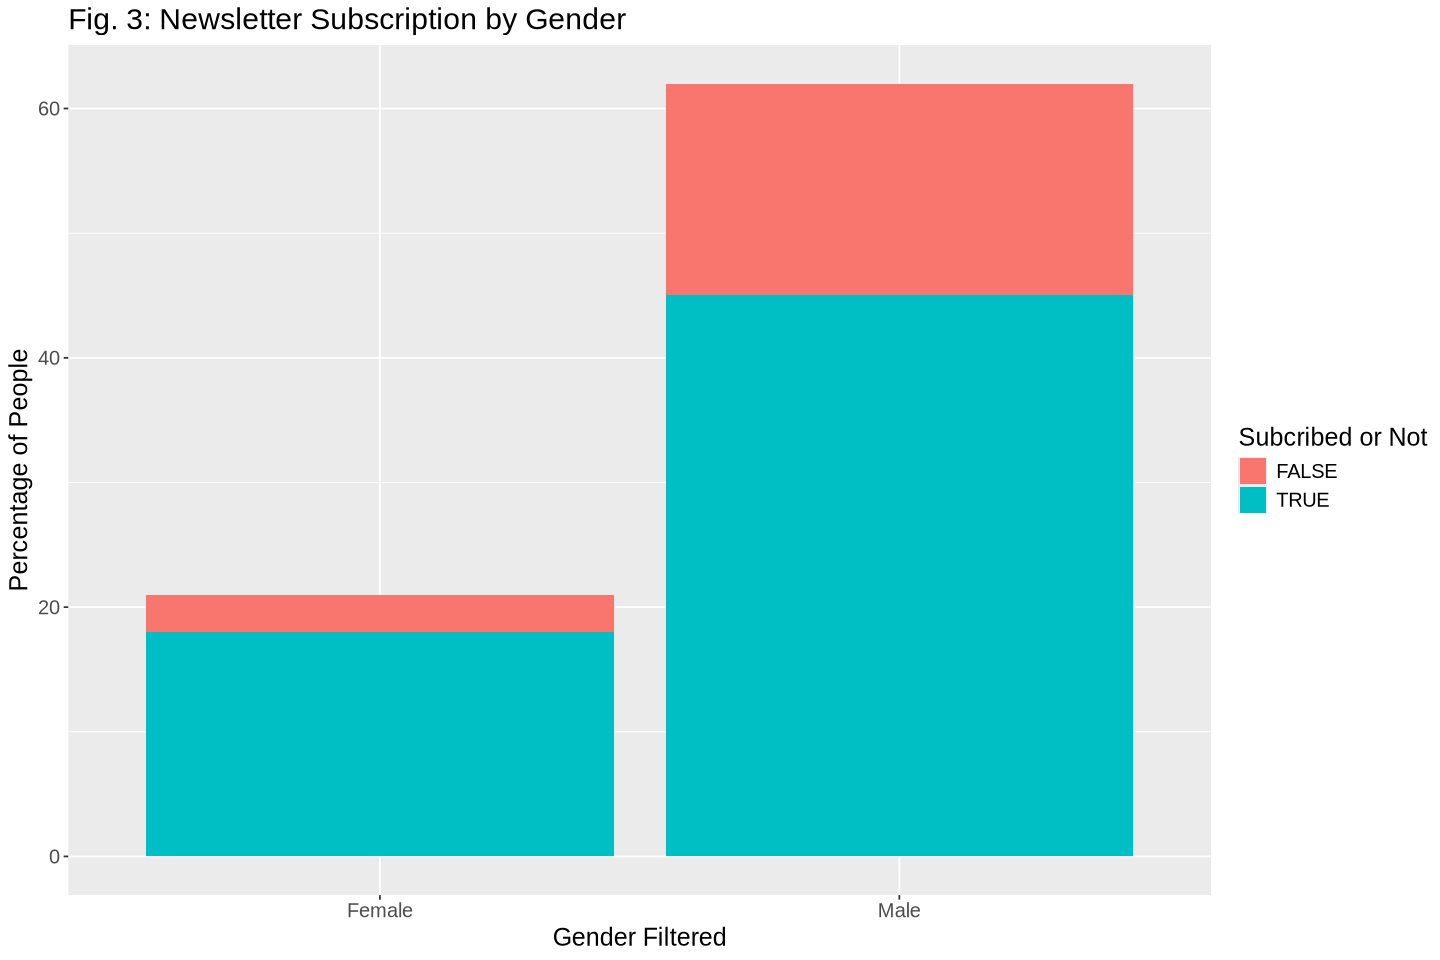

In [8]:
gender_prop_subscribe <- players |>
filter(gender==c("Female", "Male")) |>
ggplot(aes(x=gender, fill=subscribe))+
geom_bar(position="stack")+
labs(x="Gender Filtered", y="Percentage of People", fill = "Subcribed or Not", title="Fig. 3: Newsletter Subscription by Gender")+
theme(text=element_text(size=15))
gender_prop_subscribe

<Fig. 3> This plot shows females appear to have a higher subscription rate than males as females have a higher blue portion in the graph. This difference suggests gender can separate the two classes, which makes gender a good predictor for classification.

In [9]:
set.seed(1)
players_split <- initial_split(players_wrangled, prop=0.7, strat=subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [10]:
set.seed(1)

players_recipe <- recipe(subscribe~., data=players_training) |>
    step_upsample(subscribe, over_ratio=1, skip=TRUE) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())
players_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")
knn_spec

players_vfold <- vfold_cv(players_training, v=5, strata=subscribe)

k_vals <- tibble(neighbors=seq(from=1, to=20, by=1))



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 9



── Operations 

• Up-sampling based on: subscribe

• Centering for: all_predictors()

• Scaling for: all_predictors()



K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [11]:
#accuracies of predictor with different k-values, calculated based on training data when making the predictor
training_metrics <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples=players_vfold, grid=k_vals, 
              metrics = metric_set(recall, precision, accuracy)) |>
        collect_metrics() |>
        arrange(desc(mean))
head(training_metrics)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.6256917,5,0.03402196,Preprocessor1_Model02
1,accuracy,binary,0.6079051,5,0.03335533,Preprocessor1_Model01
17,accuracy,binary,0.5343874,5,0.05337286,Preprocessor1_Model17
5,accuracy,binary,0.5264822,5,0.01281693,Preprocessor1_Model05
6,accuracy,binary,0.5264822,5,0.01281693,Preprocessor1_Model06
18,accuracy,binary,0.5256917,5,0.05100193,Preprocessor1_Model18


To find the best k value, we split players_wrangled into a training set and a testing set with a 70-30 split. Then, we stratify by subscribe to make sure the proportion of subscribers and non-subscribers was similar in both sets. On the training set, we built a preprocessing recipe and a KNN classification model. In the recipe, we upsampled the non-subscribers based on subscribe to reduce the class imbalance, and centered and scaled all numeric predictors to make them on a comparable scale. In the model specification, we treated the number of neighbours as a tuning parameter. Then, use 5-fold cross validation to evaluate k from 1 to 20. 

For each k value, we calculated mean accuracy across the resamples in a tibble, where we found the model with k = 2 has the highest mean accuracy (62.57%). As a result, we selected k = 2 as our candidate for the final k value.


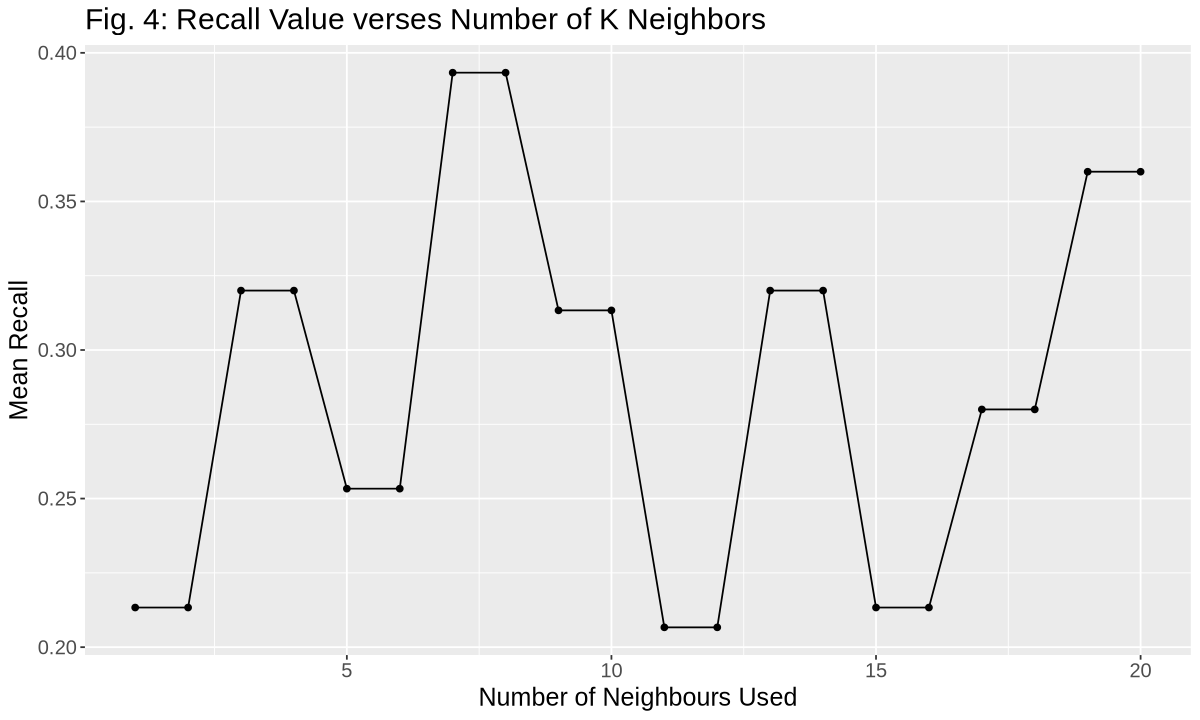

In [12]:
set.seed(1)

recall_tb<- filter(training_metrics, .metric=="recall")

precision_tb<- filter(training_metrics, .metric=="precision")

accuracy_tb<- filter(training_metrics, .metric=="accuracy")

options(repr.plot.width=10, repr.plot.height=6)
recall_plot<- ggplot(recall_tb, aes(x=neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x="Number of Neighbours Used", y= "Mean Recall")+
ggtitle("Fig. 4: Recall Value verses Number of K Neighbors")+
theme(text=element_text(size=15))
recall_plot

Recall values remain low (approximately 23 to 39%) across all K values, indicating that the model struggles to correctly identify players who truly subscribed. Even though K values of 7 and 8 achieve a slightly higher recall value (approximately 39%), the values do not have an improving trend as K increases. Thus, recall is not the best metric for selecting the best K.

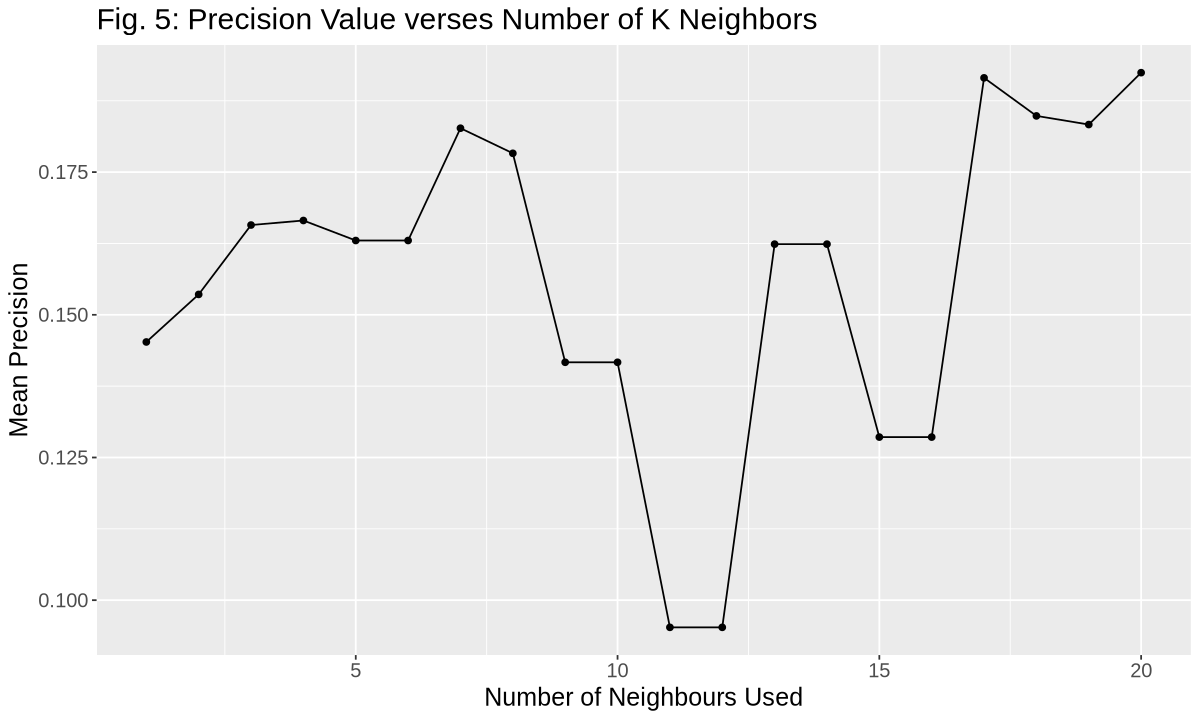

In [13]:
options(repr.plot.width=10, repr.plot.height=6)
precision_plot<- ggplot(precision_tb, aes(x=neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x="Number of Neighbours Used", y= "Mean Precision")+
ggtitle("Fig. 5: Precision Value verses Number of K Neighbors")+
theme(text=element_text(size=15))
precision_plot

Precision values remain low (approximately 5 to 19%) across all K values, indicating that the model has difficulty identifying players who were predicted as subscribed. Although K values of 7, 17, 20 show slightly higher precision (approximately 18 to 19%), the values do not show a consistent improving trend as K increases. Thus, precision is not the most suitable metric for selecting the best K.

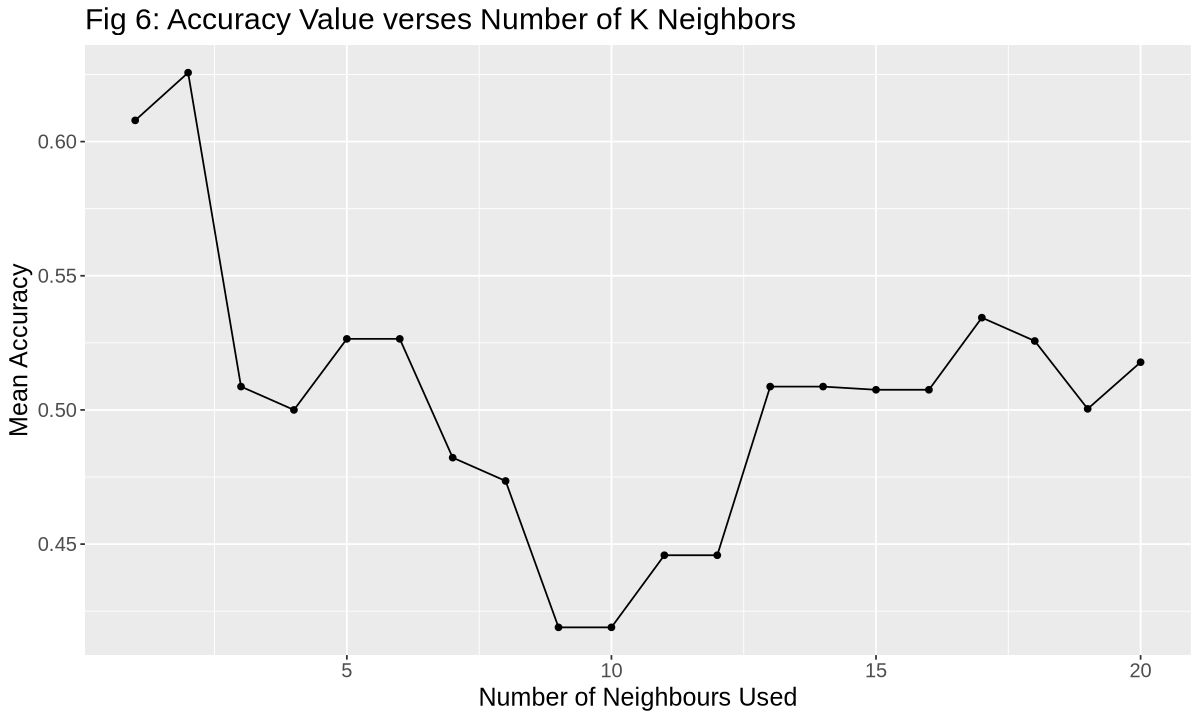

In [14]:
options(repr.plot.width=10, repr.plot.height=6)
accuracy_plot<- ggplot(accuracy_tb, aes(x=neighbors, y = mean))+
geom_point()+
geom_line()+
labs(x="Number of Neighbours Used", y= "Mean Accuracy")+
ggtitle("Fig 6: Accuracy Value verses Number of K Neighbors")+
theme(text=element_text(size=15))
accuracy_plot

Accuracy values remain relatively high (approximately 42% to 62.5%) across different K values when compared to recall and precision. While K = 2 achieves the highest accuracy (approximately 62%), the accuracy values do not steadily increase as K increases. However, accuracy is still the most reliable metric among the three, because our goal does not require prioritizing correct “subscribed” predictions over “not subscribed.” Therefore, we select K = 2 based on its highest accuracy.


In [15]:
# Apply k = 2 to training dataset to finalize making predictor
knn_spec <- nearest_neighbor(weight_func="rectangular", neighbors=2) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data=players_training)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_upsample()
• step_center()
• step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(2,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2235294
Best kernel: rectangular
Best k: 2

After choosing k, we retrain the training set with k = 2 to finalize the predictor. 

In [16]:
# testing how good our predictor is
# accuracy, precision, and recall values are based on the testing data set

players_test_predictions <- predict(knn_fit, players_testing) |>
  bind_cols(players_testing)
# players_test_predictions

players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

players_test_predictions |> pull(subscribe) |> levels()

players_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level="second")


players_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level="second")



confusion <- players_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5918367


[1] "FALSE" "TRUE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7741935


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6486486


          Truth
Prediction FALSE TRUE
     FALSE     5   13
     TRUE      7   24

After finalizing the predictor with the training set, we could evaluate the model’s performance using the testing set by applying the trained model to the testing data and combining the predictions with the original testing rows. The result players_test_predictions contain both the true subscription status and the predicted class. Then, we computed accuracy, precision, recall, and confusion metrics to determine how well the model does.

##### Accuracy #####
- The model correctly identified the subscription class for about 59% of the testing set.
##### Precision #####
- Among all players predicted as “subscribed,” 77% were actually subscribed.
##### Recall #####
- Among all players who truly subscribed, the model correctly identified about 65% of them.
##### Confusion Matrix #####
- True Positives (24): Correctly predicted as subscribed
- True Negatives (5): Correctly predicted as not subscribed
- False Positives (7): Incorrectly predicted as subscribed
- False Negatives (13): Missed actual subscribers


## Discussion ##

##### What we found #####
We found that there is a weak relationship between player newsletter subscription and these player characteristics: <code>age</code>, <code>gender</code>, <code>time played</code>, and <code>experience level</code>. This can be found from the predictor’s accuracy of 59%, even though we used an equal number of subscribed/not subscribed observations when training the predictor (because we used the step_upsample function in the recipe). Though the predictor is not very high, it is still over 50%. The precision (77%) of our predictor is quite high, though the recall (64%) was comparatively lower. This means over ¾ of “subscribed” predictions were correct, and just under ⅔ of the actual “subscribed” players were correctly identified. In our analysis, we chose to prioritize accuracy over precision or recall because there is no need to prioritize a correct “subscribed” prediction over a “not subscribed” prediction. 
The predictor’s success can be attributed to the number of variables we used to predict the subscription status. In the beginning of the project, we only used age and time played as predicting factors, and found minimal success as the accuracy was very low and did not vary much when changing the k number of neighbors. However, when we decided to add categorical variables of gender and experience level, we found more success with a higher accuracy. In the future, we could try further changing the predicting variables used by adding more (like average session time) or removing ones that decrease accuracy, which would require further experimentation and testing.

##### Is this what we expected to find? #####
We did not expect to find a predictor with an accuracy of over 50-55%, since there is no clear, assured explanation for a relationship between newsletter subscription status and any of the players’ characteristics. It is possible that investing more time into the server (having a higher total time played) or being more experienced (having a higher experience level) would indicate a greater willingness to receive updates on the game and subscribing to the newsletter. Nevertheless, the exploratory visualization showed that players with significantly higher play time made up a very small percentage of the player dataset (Fig. 1), and the percentage of subscribed veterans was comparable to the amount of subscribed amateurs (Fig. 2), even though they are very different in experience level. Gender seemed to be a better indicator of subscription status, as a very large majority of females were subscribed (Fig. 3). However, it should be noted that females also have fewer total players (making up only 23% of the dataset); the smaller sample size makes it harder to ensure a strong correlation. In the future, it would be useful to gather data that is more likely to be a strong indicator for subscription status.

##### Impact of such findings #####
There are difficulties utilizing these findings effectively in order to prove anything, since as mentioned above, our results are rather unreliable and attempting to predict and analyze more data with this model will lead to untrustworthy predictions that do not cooperate with real-life data. If this model has proven to be accurate and there is an obvious relationship between players and their characteristics, there are many situations where this information can become valuable for us. Since people (usually) only subscribe to things they are interested in, we can use the info about the characteristics of those who are subscribed and promote this Minecraft server to those who match the characteristics that are not yet subscribed to the newsletter. Unfortunately, since the predictor is not accurate enough, this may be proof that attempting to apply this approach to other topics (for example, what kinds of characteristics do people who sit in the front of the class have, etc.) may prove to be unsuccessful, and there may be potentially different perspectives we may have overlooked, and strategies that we may have missed.

##### Future questions this could lead to #####
Since the characteristics that we have chosen above do not seem to have significant links with the subscription status of the players, we still have a question that remains unanswered: what truly is dictating the subscription status? We have done the prediction with only the players.csv file, which only includes the characteristics (age, gender, experience, etc.), and we have disregarded the sessions.csv file, which also includes the session time and dates, as well as the email that links the sessions to the players.csv file. What we could do with this information is, alongside the characteristics that we already have, we could also include: longest session, average session duration, shortest session, etc. We can then also see what kind of play time tendencies different experiences have, and also include that information in our final prediction. If this also proves to be a negligible variable, we can resort to collecting more data by, say, hosting a real-life event for Minecraft players and letting people who wish to provide their e-mail see who came to the event (and also any info that can be collected during the event - like their performance, for example). 